## Importing gdrive


In [ ]:
# Connecting to Google drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Models

## Importing libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

## Importing Data

In [ ]:
padded_data = np.load('training_dataset/training_data.npy').astype(np.float32)
valid_idx = np.load('training_dataset/valid_periods.npy').astype(int)
labels = np.load('training_dataset/categories.npy')

print('The dataset is composed by %d samples of length %d t' %(padded_data.shape[0] , padded_data.shape[1]))
print('The dataset has %d indexes for each time series, before the first and after the second it s all zeros' %(valid_idx.shape[1]))
print('The dataset has %d labels' %(labels.shape[0]))

The dataset is composed by 48000 samples of length 2776 t
The dataset has 2 indexes for each time series, before the first and after the second it s all zeros
The dataset has 48000 labels


In [ ]:
train_val , test , index_train_val , index_test , labels_train_val , labels_test = train_test_split(padded_data , valid_idx , labels , test_size = 0.2 , stratify= labels)

train , val , index_train , index_val , labels_train , labels_val = train_test_split(train_val , index_train_val , labels_train_val , test_size = len(labels_test) , stratify= labels_train_val)

sets = [train , val , test , index_train , index_val , index_test , labels_train , labels_val , labels_test]
for i in sets:
  print(i.shape)

(28800, 2776)
(9600, 2776)
(9600, 2776)
(28800, 2)
(9600, 2)
(9600, 2)
(28800,)
(9600,)
(9600,)


## Exploring Data

In [ ]:
#plotting an example for each class from the order-th element of each class
def print_examples (padded_data = padded_data , valid_idx = valid_idx, labels = labels, order = 0 , instances = 1):
    classes = ['A' , 'B' , 'C' , 'D' , 'E' , 'F']
    idx = np.zeros(shape= (len(classes) , instances) , dtype=int)
    for i in range(len(classes)):
        a = np.where(labels == classes[i])[0][order : order + instances]
        idx[i] = a
    _ , axs = plt.subplots(2,3 , figsize = (18,10))
    axs = axs.reshape((-1,))
    for i in range(len(classes)):
        for j in range(instances):
            index = idx[i][j]
            start = valid_idx[index][0]
            stop = valid_idx[index][1]
            if (j == 0):
                axs[i].plot(padded_data[index,start:stop] , label = classes[i])
            else:
                axs[i].plot(padded_data[index,start:stop])
        axs[i].legend()

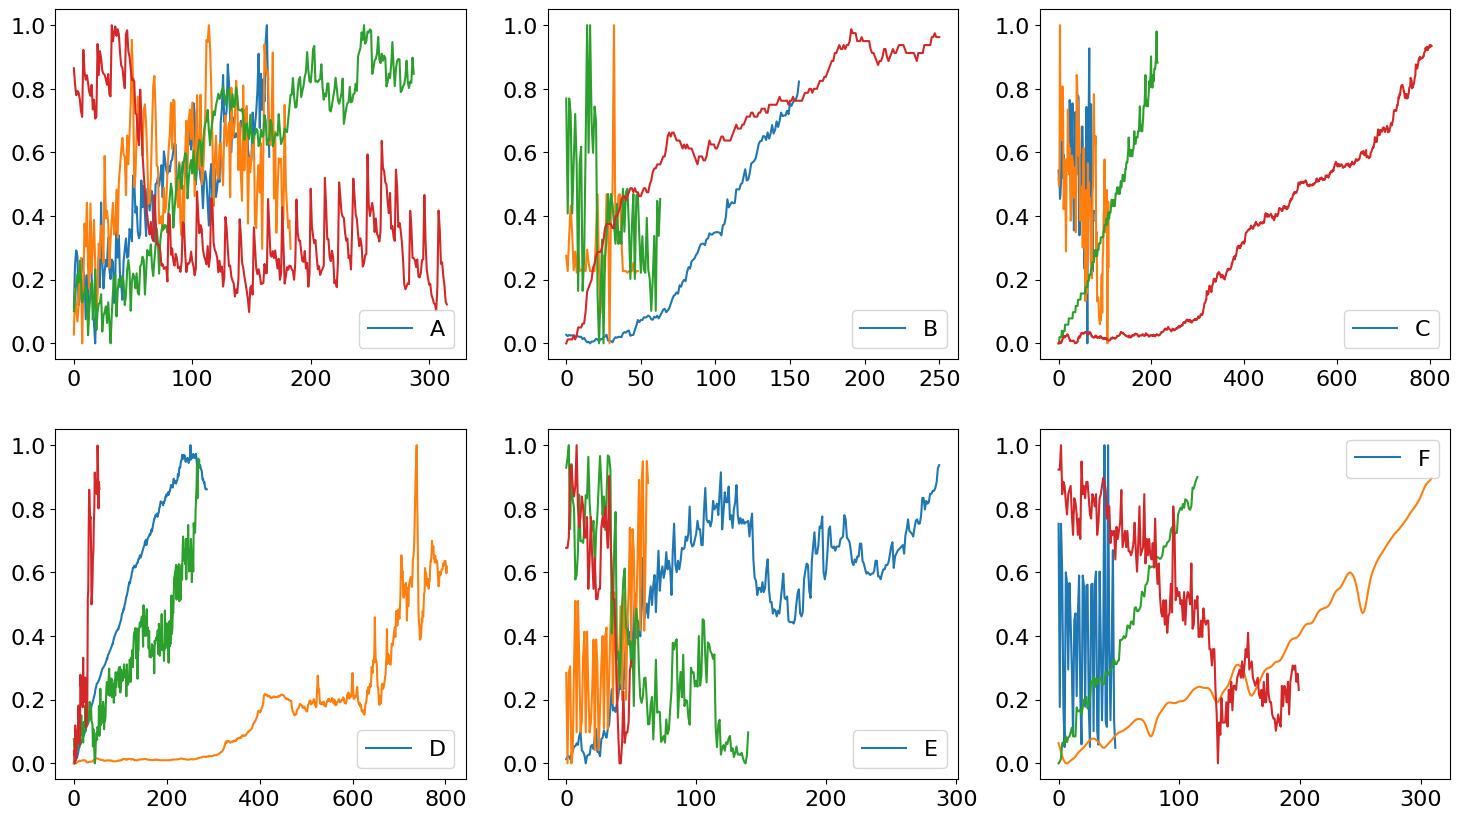

In [ ]:
# We can see that in the various labels the signals can be very eterogeneous
print_examples(padded_data = train , valid_idx = index_train , labels = labels_train , order = 0 ,instances = 4)

We notice a few things:
* series from A have clearly increasing average
* series from B seem random
* series from C seem uncorrelated
* series from D have very different lengths
* series from E are very correlated but have a sesonality
* series from F seem to be stationaty but with mean different from 0 or be very slow exponential curves

In [ ]:
#We notice that the data for different labels is highly unbalanced
classes , counts = np.unique(labels , return_counts=True)
classes_counts = dict(zip(classes, counts))
for element, count in classes_counts.items():
    print(f"Element {element}: Count {count}")

Element A: Count 5728
Element B: Count 10987
Element C: Count 10017
Element D: Count 10016
Element E: Count 10975
Element F: Count 277


In [ ]:
# calculation autocorrelation
def visualize_autocorrelation(label , offset , quantity):
  data = padded_data[np.argwhere(labels == label)].reshape(classes_counts[label] , -1)
  indexes = valid_idx[np.argwhere(labels == label)].reshape(classes_counts[label] , -1)
  print(indexes.shape)
  series = []
  ac = []

  assert offset + quantity < len(data) , 'Not enought data'

  for i in range (offset , offset + quantity + 1):
    start = indexes[i][0]
    stop = indexes[i][1]
    series.append(data[ i , start : stop + 1])
  for i in range(quantity + 1):
    ac.append(tfp.stats.auto_correlation(series[i]))
    plt.plot(ac[i])

(5728, 2)


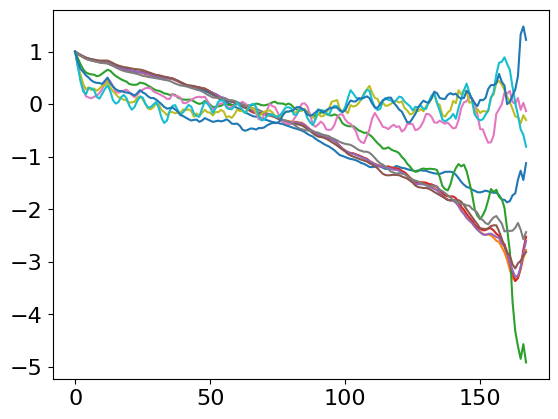

In [ ]:
visualize_autocorrelation('A' , 10 ,10)

It's very difficult to extract something from it because the time series are strongly non stationary!

## Data Preprocessing

* creation of sample time series of length 200 with labels
* division in training and testing data

In [ ]:
# getting samples of window and stride from category label with a prevision horizon of telescope length

def sample_generation (data , valid_idx , labels , label , window = 200 , stride = 2 , telescope = 50 , limit = 10000):
    assert window % stride == 0
    classes , counts = np.unique(labels , return_counts=True)
    classes_counts = dict(zip(classes, counts))
    data_used = data[np.argwhere(labels == label)].reshape(classes_counts[label] , -1)
    indexes = valid_idx[np.argwhere(labels == label)].reshape(classes_counts[label] , -1)
    samples = []
    prediction_samples = []
    for i in range(data_used.shape[0]):
        row = data_used[ i , indexes[i,0]: indexes[i,1]]
        length = row.shape[0]
        need_padding = ( length  % window ) != 0
        temp_data = row
        temp_pred = row
        if need_padding:
            padding_len = window - length % window
            padding = np.zeros((padding_len)).astype(np.float32)
            temp_data = np.concatenate((padding , row))
            temp_pred = np.concatenate((padding , row))
            assert len(temp_data) % window == 0

        for j in np.arange(0 , len(temp_data) - window - telescope - 1 , stride):
          if (j > 3 *padding_len / 4 and len(samples) < limit):
            samples.append(temp_data[j : j + window ])
            prediction_samples.append(temp_pred[ j + window : j + window + telescope])

    samples = np.array(samples)
    print('The number of samples for class' , label , 'is: ' , samples.shape[0])
    prediction_samples = np.array(prediction_samples)

    return samples , prediction_samples

In [ ]:
# describing the datastructure holding the sequences for training

window = 200
telescope = 18

train_dictionary = {}
val_dictionary = {}
test_dictionary = {}

strides = [25 , 20 , 25 , 25 , 20 , 5]
stride = {k:v  for k,v in zip(classes , strides)}

for element in classes:
    samples , pred = sample_generation(train , index_train, labels_train , element , window , stride[element] ,  telescope = telescope)
    value = [samples , pred ]
    train_dictionary[element] = value
for element in classes:
    samples , pred = sample_generation(val , index_val , labels_val , element , window , stride[element] ,  telescope = telescope)
    value = [samples , pred ]
    val_dictionary[element] = value
for element in classes:
    samples , pred = sample_generation(test , index_test, labels_test , element , window , stride[element] ,  telescope = telescope)
    value = [samples , pred ]
    test_dictionary[element] = value

The number of samples for class A is:  10000
The number of samples for class B is:  10000
The number of samples for class C is:  10000
The number of samples for class D is:  10000
The number of samples for class E is:  10000
The number of samples for class F is:  1734
The number of samples for class A is:  4599
The number of samples for class B is:  4184
The number of samples for class C is:  5291
The number of samples for class D is:  6211
The number of samples for class E is:  5136
The number of samples for class F is:  848
The number of samples for class A is:  4724
The number of samples for class B is:  4297
The number of samples for class C is:  5268
The number of samples for class D is:  6473
The number of samples for class E is:  4970
The number of samples for class F is:  507


In [ ]:
raw_data = np.zeros((1,window))
pred_data = np.zeros((1,telescope))
class_data = np.array(['A'])

def extract_data(dictionary , raw_data = raw_data, pred_data = pred_data, class_data = class_data):
  for element , value  in dictionary.items():
    raw_data = np.concatenate ((raw_data , value[0]) , axis = 0)
    pred_data = np.concatenate ((pred_data , value[1]) , axis = 0)
    a = np.full (value[0].shape[0] , element)
    class_data = np.append(class_data , a)
  raw_data = np.expand_dims(raw_data[1:] , axis = -1)
  pred_data = np.expand_dims(pred_data[1:] , axis = -1)
  class_data = np.expand_dims(class_data[1:] , axis = -1)
  print(raw_data.shape)
  print(pred_data.shape)
  print(class_data.shape)
  return raw_data , pred_data , class_data

train_samples , train_pred , train_labels = extract_data(train_dictionary)
val_samples , val_pred , val_labels = extract_data(val_dictionary)
test_samples , test_pred , test_labels = extract_data(test_dictionary)



(51734, 200, 1)
(51734, 18, 1)
(51734, 1)
(26269, 200, 1)
(26269, 18, 1)
(26269, 1)
(26239, 200, 1)
(26239, 18, 1)
(26239, 1)


## Model 6 : monovariate direct estimation

In [ ]:
input_shape = train_samples.shape[1:]
output_shape = train_pred.shape[1:]
print(input_shape)
print(output_shape)

batch_size = 64
epochs = 200

(200, 1)
(18, 1)


In [ ]:
def build_seq2seq_model(input_shape, output_shape , hidden_units = 64):

    input_encoder = tfkl.Input(shape=input_shape, name='input_layer')

    #Encoder

    encoder = tfkl.LSTM(hidden_units, return_state = True , return_sequences=True)

    encoder_stacked_h , state_h , state_c = encoder(input_encoder)

    state_h = tfkl.BatchNormalization(momentum = 0.6)(state_h)

    state_c = tfkl.BatchNormalization(momentum = 0.6)(state_c)

    encoded_states = [state_h , state_c]

    #Decoder

    decoder = tfkl.RepeatVector(output_shape[0])(state_h)

    decoder_LSTM = tfkl.LSTM(hidden_units, return_sequences=True, return_state=False)

    decoder_outputs = decoder_LSTM(decoder , initial_state = encoded_states)

    attention = tfkl.Dot (axes = [2,2])([decoder_outputs , encoder_stacked_h] )

    attention = tfkl.Activation('softmax')(attention)

    context = tfkl.Dot(axes=[2,1])([attention, encoder_stacked_h])

    context = tfkl.BatchNormalization(momentum = 0.6)(context)

    decoder_combined_context = tfkl.Concatenate()([context, decoder_outputs])

    outputs = tfkl.TimeDistributed(tfkl.Dense(output_shape[1]))(decoder_combined_context)

    # Construct the model by connecting input and output layers
    model = tfk.Model(inputs= input_encoder ,  outputs= outputs , name='model_6')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())

    return model

In [ ]:
model = build_seq2seq_model(input_shape, output_shape , 512)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 lstm_17 (LSTM)              [(None, 200, 512),           1052672   ['input_layer[0][0]']         
                              (None, 512),                                                        
                              (None, 512)]                                                        
                                                                                                  
 batch_normalization_15 (Ba  (None, 512)                  2048      ['lstm_17[0][1]']             
 tchNormalization)                                                                          

In [ ]:
history = model.fit(
    train_samples,
    train_pred,
    batch_size = batch_size,
    validation_data = (val_samples, val_pred),
    epochs = epochs,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', min_delta = 1e-4 , mode='min', patience= 15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5),
        tfk.callbacks.ModelCheckpoint(filepath = 'Model_checkpoints/model_5.keras')
    ]
).history

Epoch 1/200
809/809 [==============================] - 30s 32ms/step - loss: 0.0268 - val_loss: 0.0152 - lr: 0.0010
Epoch 2/200
809/809 [==============================] - 24s 30ms/step - loss: 0.0138 - val_loss: 0.0136 - lr: 0.0010
Epoch 3/200
809/809 [==============================] - 25s 30ms/step - loss: 0.0128 - val_loss: 0.0123 - lr: 0.0010
Epoch 4/200
809/809 [==============================] - 25s 30ms/step - loss: 0.0123 - val_loss: 0.0122 - lr: 0.0010
Epoch 5/200
809/809 [==============================] - 24s 30ms/step - loss: 0.0123 - val_loss: 0.0117 - lr: 0.0010
Epoch 6/200
809/809 [==============================] - 25s 30ms/step - loss: 0.0121 - val_loss: 0.0127 - lr: 0.0010
Epoch 7/200
809/809 [==============================] - 25s 30ms/step - loss: 0.0121 - val_loss: 0.0116 - lr: 0.0010
Epoch 8/200
809/809 [==============================] - 25s 30ms/step - loss: 0.0120 - val_loss: 0.0114 - lr: 0.0010
Epoch 9/200
809/809 [==============================] - 24s 30ms/step - l

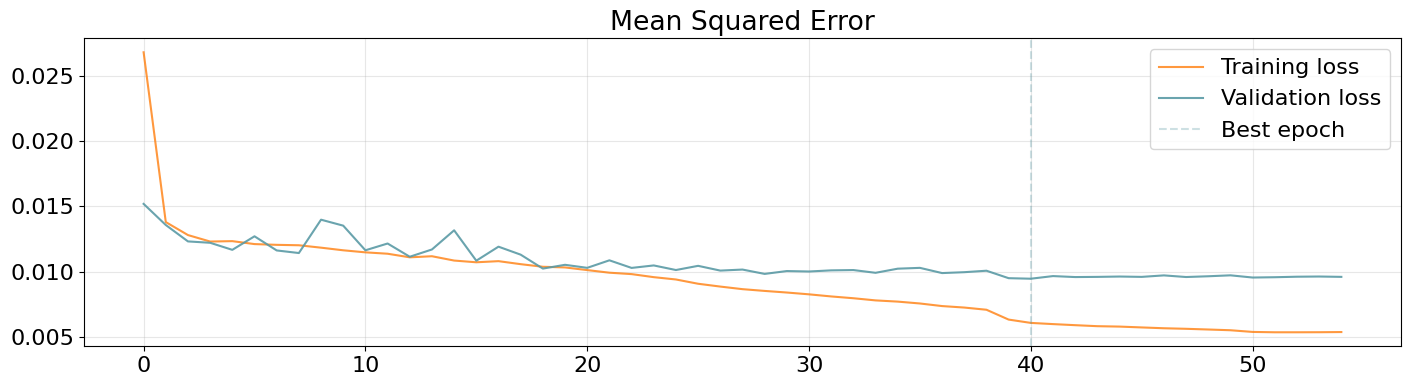

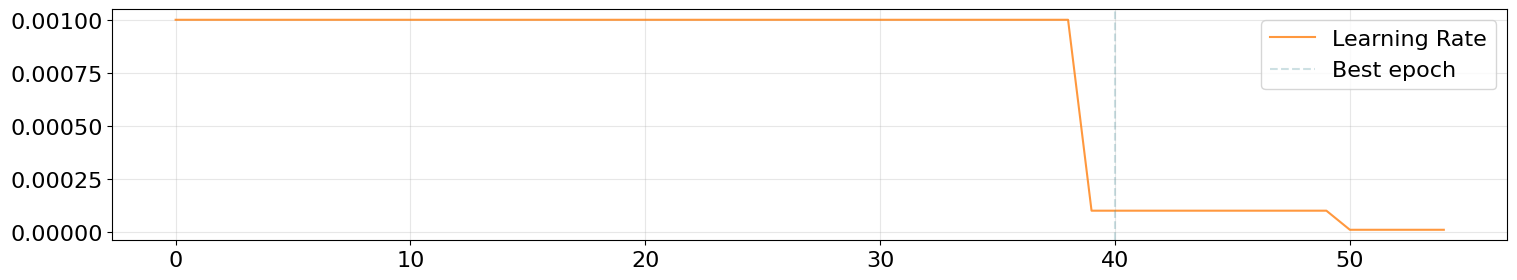

In [ ]:
last_epoch = len(history)

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x= best_epoch , label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x= best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('Saved_Models/Model6.h5')


In [ ]:
model = tfk.models.load_model('Saved_Models/Model6.h5')

In [ ]:
# Predict the test set using the model
predictions = model.predict(test_samples, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(test_pred.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(test_pred.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (26239, 18, 1)
Mean Squared Error: 0.008877480402588844
Mean Absolute Error: 0.06069554015994072


In [ ]:
def inspect_prediction(X, y, pred ,scope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,X.shape[0])

    row = X[idx]
    pred = pred[idx]
    y = y[idx]

    print(row.shape , pred.shape , y.shape)
    continuum = np.concatenate((row , pred )).reshape((-1))
    destiny = np.concatenate((row , y)).reshape((-1))

    print(destiny.shape)

    diff = scope

    plt.plot(row)
    plt.plot( np.arange(window - 1, window + diff), destiny[- 1 -diff:] , color='orange' , label = 'true value')
    plt.plot( np.arange(window - 1 , window + diff), continuum[ -1 - diff :], color='green' , label = 'predicted value')
    plt.legend()
    plt.show()

(200, 1) (18, 1) (18, 1)
(218,)


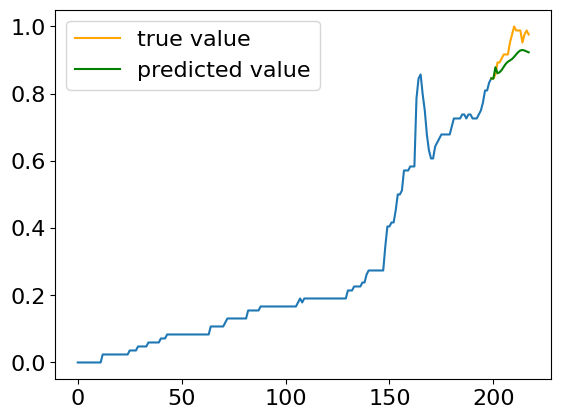

In [ ]:
inspect_prediction(test_samples , test_pred ,  predictions, 18  )

In [ ]:
predictions.shape

(26239, 18, 1)

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = np.mean(np.abs(y_test[:,i,0]-predictions[:,i,0]), axis=0)
    maes.append(ft_maes)
maes = np.array(maes)

NameError: ignored

In [ ]:
print(maes)